In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
import scipy.stats as stats

In [2]:
df_union = pd.read_parquet('Datawarehouse/X_subway.parquet')
df_reseñas = pd.read_parquet('Datawarehouse/reviewstexto.parquet')

## Rellenar Atributos con Reseñas

In [3]:
subway_id_list = df_union['id_restaurante'].to_list()

# Filtrar el DataFrame
df_reseñas = df_reseñas[df_reseñas['id_restaurante'].isin(subway_id_list)]

df_reseñas.dropna(how='any', inplace= True)

In [4]:
# Filtrar las reseñas que contienen la palabra 'friendly' y obtener los identificadores de los restaurantes correspondientes
restaurantes_con_friendly = df_reseñas[df_reseñas['texto'].str.contains('friendly', case=False)]['id_restaurante'].unique()

# Actualizar las columnas en el DataFrame de restaurantes basándote en los identificadores obtenidos
for restaurante_id in restaurantes_con_friendly:
    # Actualizar la columna 'crowd_Family friendly' en True para los restaurantes que contienen 'friendly'
    df_union.loc[df_union['id_restaurante'] == restaurante_id, 'crowd_Family-friendly'] = True

C:\Users\Luka\AppData\Local\Temp\ipykernel_9048\176040819.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_union.loc[df_union['id_restaurante'] == restaurante_id, 'crowd_Family-friendly'] = True


In [5]:
# Filtrar las reseñas que contienen la palabra 'clean' y obtener los identificadores de los restaurantes correspondientes
restaurantes_con_clean = df_reseñas[df_reseñas['texto'].str.contains('clean', case=False)]['id_restaurante'].unique()

# Actualizar las columnas en el DataFrame de restaurantes basándote en los identificadores obtenidos
for restaurante_id in restaurantes_con_clean:
    # Actualizar la columna 'health_Staff required to disinfect surfaces between visits' en True para los restaurantes que contienen 'clean'
    df_union.loc[df_union['id_restaurante'] == restaurante_id, 'health_Staff required to disinfect surfaces between visits'] = True

C:\Users\Luka\AppData\Local\Temp\ipykernel_9048\3647611589.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_union.loc[df_union['id_restaurante'] == restaurante_id, 'health_Staff required to disinfect surfaces between visits'] = True


## Puntaje

In [6]:
columnas_ignorar = ['index', 'latitud_x','longitud_x','origen_x','id_estado_1','id_estado_3','id_estado_4','id_estado_5',
    'id_estado_6','id_estado_7','id_estado_8','id_estado_9','id_estado_10','id_estado_11','id_estado_12','id_estado_13',
    'id_estado_14','id_estado_15','id_estado_16','id_estado_17','id_estado_18','id_estado_19','id_estado_20','id_estado_21'
    'id_estado_22','id_estado_23','id_estado_24','id_estado_25','id_estado_26',
    'id_estado_27','id_estado_28','id_estado_29','id_estado_30','id_estado_31','id_estado_32','id_estado_33','id_estado_34',
    'id_estado_35','id_estado_36','id_estado_37','id_estado_38','id_estado_39','id_estado_40','id_estado_41','id_estado_42',
    'id_estado_43','id_estado_44','id_estado_45','id_estado_46',
    'id_estado_47','id_estado_48','id_estado_49','id_estado_50','level_0','id_restaurante','id_estado','nombre','categorias',
    'cantidad_resenas','latitud_y','longitud_y','atributos','calificacion','origen_y', 'en_zona_turistica','puntaje']

def calcular_puntaje(df, columnas_ignorar):
    """
    Calcula el puntaje de los restaurantes y agrega una columna nueva al dataframe con el puntaje.
    
    Args:
    df (pd.DataFrame): DataFrame de restaurantes.
    columnas_ignorar (list): Lista de nombres de columnas que no se sumarán para calcular el puntaje base.
    
    Returns:
    pd.DataFrame: DataFrame con una columna nueva 'puntaje'.
    """
    # Identificar las columnas de cada grupo
    grupos = {
        'service': [col for col in df.columns if col.startswith('service')],
        'access': [col for col in df.columns if col.startswith('access')],
        'amen': [col for col in df.columns if col.startswith('amen')],
        'atmos': [col for col in df.columns if col.startswith('atmos')],
        'crowd': [col for col in df.columns if col.startswith('crowd')],
        'dining': [col for col in df.columns if col.startswith('dining')],
        'health': [col for col in df.columns if col.startswith('health')],
        'high': [col for col in df.columns if col.startswith('high')],
        'offer': [col for col in df.columns if col.startswith('offer')],
        'pay': [col for col in df.columns if col.startswith('pay')],
        'popular': [col for col in df.columns if col.startswith('popular')],
    }
    
    # Identificar todas las columnas que no están en la lista de columnas a ignorar
    columnas_suma = [col for col in df.columns if col not in columnas_ignorar]
    
    # Calcular el puntaje base sumando los valores de las columnas especificadas
    df['puntaje'] = df[columnas_suma].sum(axis=1)
    
    # Sumar un punto extra por cada grupo que tiene más de un valor presente
    for nombre_grupo, columnas_grupo in grupos.items():
        df['extra'] = df[columnas_grupo].apply(lambda row: row.sum() > 1, axis=1).astype(int)
        df['puntaje'] += df['extra']
    
    # Eliminar la columna 'extra' utilizada para el cálculo
    df.drop(columns=['extra'], inplace=True)
    
    return df

In [7]:
def calcular_puntaje_grupos(df, columnas_ignorar):
    """
    Calcula el puntaje de los restaurantes y agrega columnas nuevas al dataframe con los puntajes de cada grupo.
    
    Args:
    df (pd.DataFrame): DataFrame de restaurantes.
    columnas_ignorar (list): Lista de nombres de columnas que no se sumarán para calcular el puntaje base.
    
    Returns:
    pd.DataFrame: DataFrame con columnas nuevas de puntajes por grupo.
    """
    # Identificar las columnas de cada grupo
    grupos = {
        'service': [col for col in df.columns if col.startswith('service')],
        'access': [col for col in df.columns if col.startswith('access')],
        'amen': [col for col in df.columns if col.startswith('amen')],
        'atmos': [col for col in df.columns if col.startswith('atmos')],
        'crowd': [col for col in df.columns if col.startswith('crowd')],
        'dining': [col for col in df.columns if col.startswith('dining')],
        'health': [col for col in df.columns if col.startswith('health')],
        'high': [col for col in df.columns if col.startswith('high')],
        'offer': [col for col in df.columns if col.startswith('offer')],
        'pay': [col for col in df.columns if col.startswith('pay')],
        'popular': [col for col in df.columns if col.startswith('popular')],
    }
    
    # Identificar todas las columnas que no están en la lista de columnas a ignorar
    columnas_suma = [col for col in df.columns if col not in columnas_ignorar]
    
    # Crear columnas para cada grupo y calcular el puntaje de cada grupo
    for nombre_grupo, columnas_grupo in grupos.items():
        df[nombre_grupo + '_puntaje'] = df[columnas_grupo].sum(axis=1)
        df[nombre_grupo + '_extra'] = df[columnas_grupo].apply(lambda row: row.sum() > 1, axis=1).astype(int)
        df[nombre_grupo + '_puntaje'] += df[nombre_grupo + '_extra']
        df.drop(columns=[nombre_grupo + '_extra'], inplace=True)
    
    return df

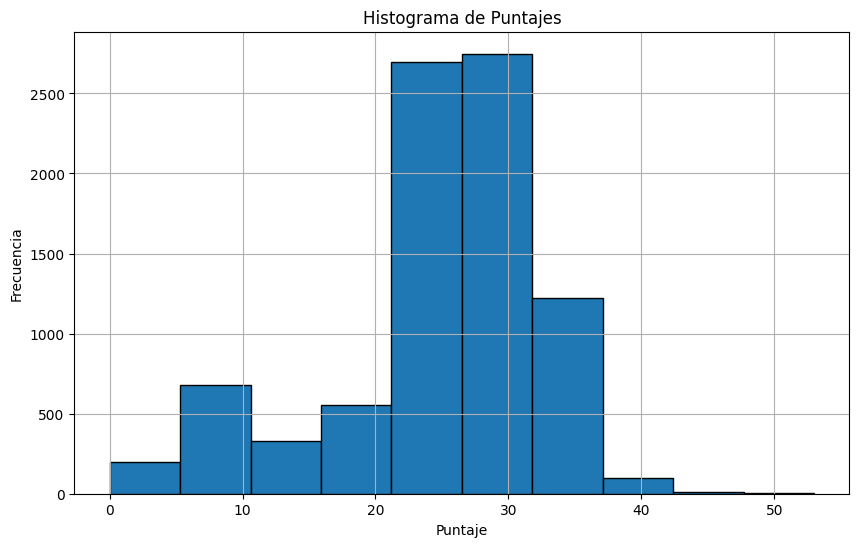

In [8]:
df_union = calcular_puntaje(df_union, columnas_ignorar)
df_union = calcular_puntaje_grupos(df_union, columnas_ignorar)

# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(df_union['puntaje'], bins=10, edgecolor='black')
plt.title('Histograma de Puntajes')
plt.xlabel('Puntaje')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

## Selección de columnas

In [9]:
X = df_union[['cantidad_resenas', 'calificacion', 'puntaje']]

In [10]:
# Crear instancias de los escaladores
scaler_calificacion = MinMaxScaler()  # Normalización
scaler_cantidad_resenas = StandardScaler()  # Z-score Scaling
scaler_puntaje = StandardScaler()  # Z-score Scaling

# Seleccionar las columnas relevantes
calificacion = ['calificacion']
cantidad_resenas = ['cantidad_resenas']
puntaje = ['puntaje']

# Aplicar el escalamiento a cada columna por separado
X[calificacion] = scaler_calificacion.fit_transform(X[calificacion])
X[cantidad_resenas] = scaler_cantidad_resenas.fit_transform(X[cantidad_resenas])
X[puntaje] = scaler_puntaje.fit_transform(X[puntaje])

C:\Users\Luka\AppData\Local\Temp\ipykernel_9048\1912816736.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[calificacion] = scaler_calificacion.fit_transform(X[calificacion])
C:\Users\Luka\AppData\Local\Temp\ipykernel_9048\1912816736.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cantidad_resenas] = scaler_cantidad_resenas.fit_transform(X[cantidad_resenas])
C:\Users\Luka\AppData\Local\Temp\ipykernel_9048\1912816736.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [11]:
X_2 = X[['puntaje', 'cantidad_resenas']]
X_3 = X[['puntaje', 'cantidad_resenas', 'calificacion']]

## Metodo del Codo

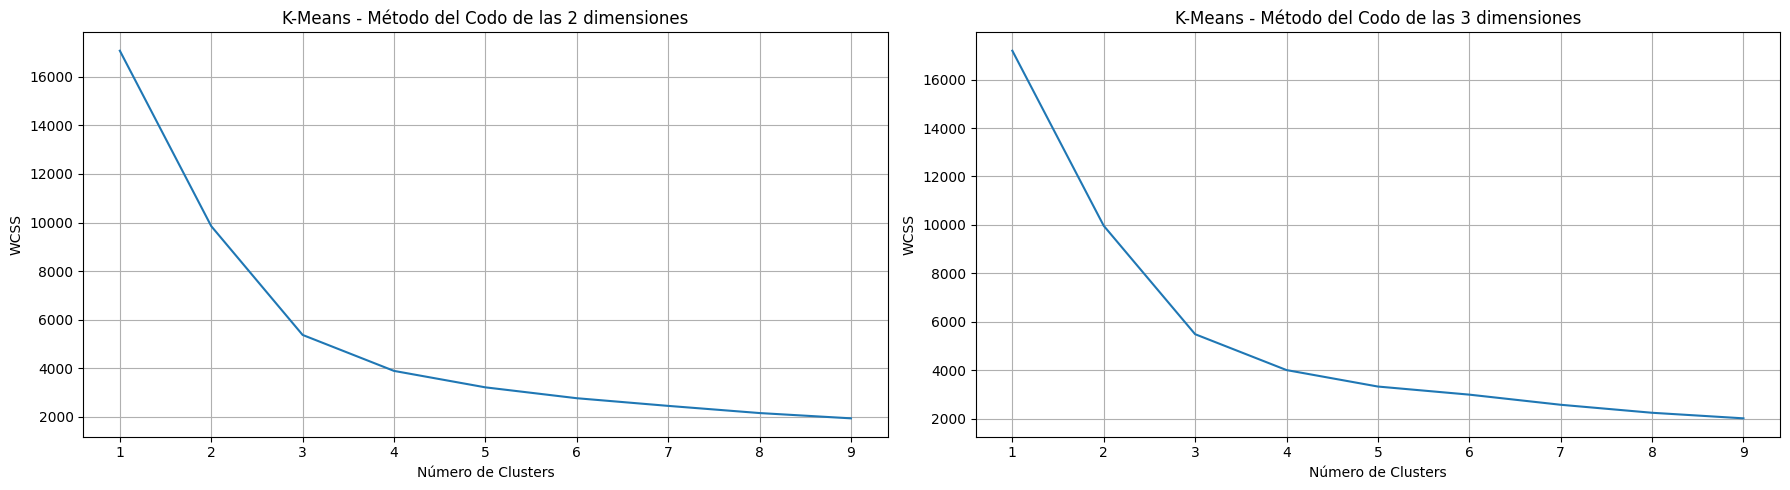

In [85]:
# Determinar el número óptimo de clusters usando el método del codo para K-Means
wcss_kmeans_2d = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X_2)
    wcss_kmeans_2d.append(kmeans.inertia_)

wcss_kmeans_3d = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X_3)
    wcss_kmeans_3d.append(kmeans.inertia_)

# Graficar los resultados
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Gráfico para K-Means 2D
axes[0].plot(range(1, 10), wcss_kmeans_2d)
axes[0].set_title('K-Means - Método del Codo de las 2 dimensiones')
axes[0].set_xlabel('Número de Clusters')
axes[0].set_ylabel('WCSS')
axes[0].grid(True)  # Agregar grid al primer gráfico

# Gráfico para K-Means 3D
axes[1].plot(range(1, 10), wcss_kmeans_3d)
axes[1].set_title('K-Means - Método del Codo de las 3 dimensiones')
axes[1].set_xlabel('Número de Clusters')
axes[1].set_ylabel('WCSS')
axes[1].grid(True)  # Agregar grid al primer gráfico

plt.tight_layout()
plt.show()

## Modelo de Clusterización K-Means y Visualización

In [16]:
n_clusters = 4

# Crear el modelo de clustering de 3 dimensiones
kmeans_3d = KMeans(n_clusters=n_clusters, random_state=42)

# Ajustar el modelo a tus datos (sin tener en cuenta el índice)
labels_kmeans_3d = kmeans_3d.fit_predict(X_3)

# Crear el modelo de clustering de 2 dimensiones
kmeans_2d = KMeans(n_clusters=n_clusters, random_state=42)

# Ajustar el modelo a tus datos (sin tener en cuenta el índice)
labels_kmeans_2d = kmeans_2d.fit_predict(X_2)

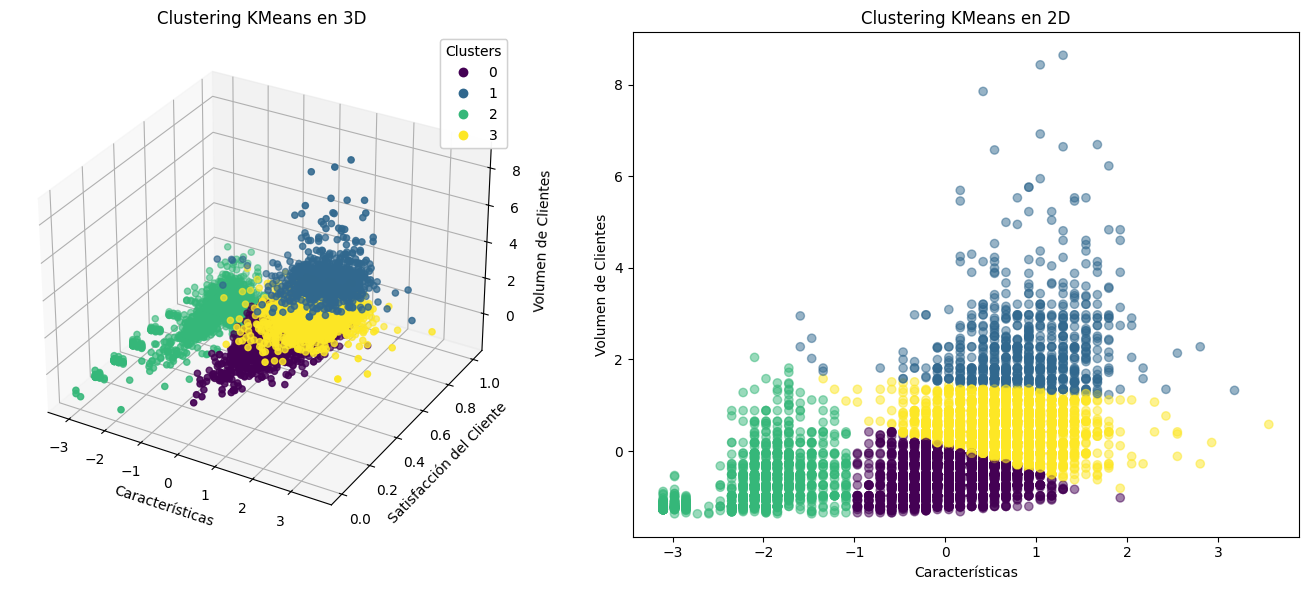

In [17]:
X_3 = np.array(X_3)
X_2 = np.array(X_2)

# Crear subplots
fig = plt.figure(figsize=(14, 6))

# Gráfico 3D para KMeans
ax1 = fig.add_subplot(121, projection='3d')
scatter_kmeans = ax1.scatter(X_3[:, 0], X_3[:, 2], X_3[:, 1], c=labels_kmeans_3d, cmap='viridis')
ax1.set_title('Clustering KMeans en 3D')
ax1.set_xlabel('Características')
ax1.set_ylabel('Satisfacción del Cliente')
ax1.set_zlabel('Volumen de Clientes')

# Agregar leyenda
legend1 = ax1.legend(*scatter_kmeans.legend_elements(), title="Clusters")
ax1.add_artist(legend1)

# Gráfico 2D para PCA
ax2 = fig.add_subplot(122)
scatter_pca = ax2.scatter(X_2[:, 0], X_2[:, 1], c=labels_kmeans_3d, cmap='viridis', alpha=0.5)
ax2.set_xlabel('Características')
ax2.set_ylabel('Volumen de Clientes')
ax2.set_title('Clustering KMeans en 2D')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

## Analisis de los Grupos

In [18]:
columns_rescue = ['id_restaurante',
 'id_estado', 
'cantidad_resenas', 
'calificacion',
'puntaje',
 'service_puntaje',
 'access_puntaje',
 'amen_puntaje',
 'atmos_puntaje',
 'crowd_puntaje',
 'dining_puntaje',
 'health_puntaje',
 'high_puntaje',
 'offer_puntaje',
 'pay_puntaje',
 'popular_puntaje']

In [19]:
df_union = df_union[columns_rescue]

In [20]:
df_union['gruop'] = labels_kmeans_3d

In [21]:
df_union['volumen_clientes'] = df_union['cantidad_resenas'] * 100

In [29]:
df_union['puntaje'] = pd.to_numeric(df_union['puntaje'], errors='coerce')
df_union['crowd_puntaje'] = pd.to_numeric(df_union['crowd_puntaje'], errors='coerce')
df_union['health_puntaje'] = pd.to_numeric(df_union['health_puntaje'], errors='coerce')

In [30]:
df_union.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8537 entries, 0 to 8536
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id_restaurante    8537 non-null   object 
 1   id_estado         8537 non-null   int64  
 2   cantidad_resenas  8537 non-null   int64  
 3   calificacion      8537 non-null   float64
 4   puntaje           8537 non-null   float64
 5   service_puntaje   8537 non-null   int64  
 6   access_puntaje    8537 non-null   int64  
 7   amen_puntaje      8537 non-null   int64  
 8   atmos_puntaje     8537 non-null   int64  
 9   crowd_puntaje     8537 non-null   int64  
 10  dining_puntaje    8537 non-null   int64  
 11  health_puntaje    8537 non-null   int64  
 12  high_puntaje      8537 non-null   int64  
 13  offer_puntaje     8537 non-null   int64  
 14  pay_puntaje       8537 non-null   int64  
 15  popular_puntaje   8537 non-null   int64  
 16  gruop             8537 non-null   int32  


In [49]:
# Obtener estadísticas descriptivas por grupo
descriptive_stats = df_union.groupby('gruop')[['service_puntaje', 'access_puntaje', 'amen_puntaje', 'crowd_puntaje', 'dining_puntaje', 'health_puntaje', 'offer_puntaje', 'pay_puntaje', 'volumen_clientes', 'calificacion']].describe()
descriptive_stats['service_puntaje'].head()

,count,mean,std,min,25%,50%,75%,max
gruop,,,,,,,,
0,3719.0,4.241194,0.698621,1.0,4.0,4.0,5.0,6.0
1,756.0,4.560847,0.636839,3.0,4.0,5.0,5.0,6.0
2,1228.0,3.307003,1.517424,0.0,3.0,4.0,4.0,5.0
3,2834.0,4.498589,0.619285,1.0,4.0,5.0,5.0,6.0


In [50]:
descriptive_stats['access_puntaje'].head()

,count,mean,std,min,25%,50%,75%,max
gruop,,,,,,,,
0,3719.0,1.689433,1.364096,0.0,1.0,1.0,1.0,6.0
1,756.0,2.828042,1.833336,1.0,1.0,3.0,5.0,6.0
2,1228.0,0.495928,1.160677,0.0,0.0,0.0,0.0,5.0
3,2834.0,2.492943,1.764293,0.0,1.0,1.0,4.0,6.0


In [51]:
descriptive_stats['amen_puntaje'].head()

,count,mean,std,min,25%,50%,75%,max
gruop,,,,,,,,
0,3719.0,1.272923,0.694632,0.0,1.0,1.0,1.0,5.0
1,756.0,2.149471,1.037132,0.0,1.0,3.0,3.0,6.0
2,1228.0,0.083062,0.293265,0.0,0.0,0.0,0.0,3.0
3,2834.0,1.800635,1.018772,0.0,1.0,1.0,3.0,6.0


In [52]:
descriptive_stats['crowd_puntaje'].head()

,count,mean,std,min,25%,50%,75%,max
gruop,,,,,,,,
0,3719.0,1.728959,1.220101,0.0,1.0,1.0,3.0,5.0
1,756.0,3.119048,1.115386,0.0,3.0,3.0,4.0,5.0
2,1228.0,0.155537,0.362564,0.0,0.0,0.0,0.0,1.0
3,2834.0,2.705011,1.238486,0.0,1.0,3.0,4.0,5.0


In [53]:
descriptive_stats['dining_puntaje'].head()

,count,mean,std,min,25%,50%,75%,max
gruop,,,,,,,,
0,3719.0,3.229363,0.780228,0.0,3.0,3.0,4.0,7.0
1,756.0,3.715608,0.662981,1.0,3.0,4.0,4.0,7.0
2,1228.0,1.791531,1.196515,0.0,1.0,1.0,3.0,4.0
3,2834.0,3.624559,0.683250,1.0,3.0,4.0,4.0,7.0


In [54]:
descriptive_stats['health_puntaje'].head()

,count,mean,std,min,25%,50%,75%,max
gruop,,,,,,,,
0,3719.0,0.567357,0.966752,0.0,0.0,0.0,1.0,4.0
1,756.0,1.578042,1.288973,0.0,0.0,1.0,3.0,5.0
2,1228.0,0.140879,0.354994,0.0,0.0,0.0,0.0,3.0
3,2834.0,1.280875,1.262904,0.0,0.0,1.0,3.0,6.0


In [55]:
descriptive_stats['offer_puntaje'].head()

,count,mean,std,min,25%,50%,75%,max
gruop,,,,,,,,
0,3719.0,5.454692,0.758689,1.0,5.0,5.0,6.0,7.0
1,756.0,6.148148,0.886550,0.0,6.0,6.0,7.0,7.0
2,1228.0,0.143322,0.689173,0.0,0.0,0.0,0.0,5.0
3,2834.0,5.938603,0.795175,0.0,5.0,6.0,6.0,7.0


In [56]:
descriptive_stats['pay_puntaje'].head()

,count,mean,std,min,25%,50%,75%,max
gruop,,,,,,,,
0,3719.0,2.576499,0.825558,0.0,3.0,3.0,3.0,4.0
1,756.0,2.789683,0.636172,1.0,3.0,3.0,3.0,4.0
2,1228.0,2.039088,1.217946,0.0,1.0,3.0,3.0,4.0
3,2834.0,2.733592,0.706948,1.0,3.0,3.0,3.0,5.0


In [57]:
descriptive_stats['volumen_clientes'].head()

,count,mean,std,min,25%,50%,75%,max
gruop,,,,,,,,
0,3719.0,3438.316752,1486.287498,200.0,2400.0,3500.0,4700.0,7800.0
1,756.0,15842.328042,4215.465927,11300.0,12800.0,14650.0,17325.0,43200.0
2,1228.0,3093.566775,2461.938327,100.0,1200.0,2600.0,4500.0,14800.0
3,2834.0,7971.136203,1904.767547,2500.0,6700.0,7800.0,9400.0,12800.0


In [58]:
descriptive_stats['calificacion'].head()

,count,mean,std,min,25%,50%,75%,max
gruop,,,,,,,,
0,3719.0,3.708847,0.464938,1.599609,3.400391,3.800781,4.000000,5.000000
1,756.0,3.978306,0.255987,2.900391,3.800781,4.000000,4.199219,4.500000
2,1228.0,3.498401,0.678316,1.000000,3.199219,3.699219,4.000000,5.000000
3,2834.0,3.916550,0.324644,2.300781,3.699219,4.000000,4.101562,4.699219
